In [1]:
# Replicate ITI results, make sure ITI utils and probing utils work right

#%%
%load_ext autoreload
%autoreload 2
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm
# from utils.probing_utils import ModelActs
from utils.dataset_utils import CounterFact_Dataset, TQA_MC_Dataset, EZ_Dataset

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from utils.iti_utils import patch_iti

from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims
import os
from torch import Tensor

from utils.analytics_utils import plot_z_probe_accuracies, plot_resid_probe_accuracies
from utils.new_probing_utils import ModelActsLargeSimple, ChunkedModelActs
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

/tmp/ipykernel_3139396/2423933810.py:10: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_3139396/2423933810.py:11: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Format raw activations

Format unformatted activation files with each prompt being a single file, into formatted activations of each component's collated acts.

Only has to be done once.

In [68]:
# N = 2550 #upper bound the global (level 0) index
d_head = 128
n_layers = 80
n_heads = 64
# num_params = "70b"

from utils.cache_utils import create_probe_dataset, format_logits
data_dir = "/mnt/ssd-2/jamescampbell3"
act_type = "z"
run_id = 33
save_dir = f"/home/phillipguo/formatted_runs/run_{run_id}"

seq_pos = -3
# azaria_mitchell_short_splits = ['facts', 'neg_facts', 'conj_neg_facts', 'companies', 'neg_companies', 'conj_neg_companies']
azaria_mitchell_short_splits = ['cities', 'capitals', 'companies', 'animals', 'elements', 'inventions', 'facts']
azaria_mitchell_splits = [f'azaria_mitchell_{split}' for split in azaria_mitchell_short_splits]
from datasets import load_dataset
# dataset = load_dataset("notrichardren/deception-evals")
# dataset = load_dataset("notrichardren/azaria-mitchell")
dataset = load_dataset("notrichardren/truthfulness_high_quality")
run_folder = f"/mnt/ssd-2/jamescampbell3/data/large_run_{run_id}"

# modes = ["neutral_unprompted", "elements_liar"]
modes = ["honest", "neutral", "liar"]
for mode in modes:
    for split in azaria_mitchell_splits:
        create_probe_dataset(run_id=run_id, seq_pos=seq_pos, prompt_tag=mode, act_type=act_type, data_dir=data_dir, splits=[split], save_path=save_dir, inference_path=f"inference_outputs/inference_output_{run_id}_honest.csv")

        # indices = dataset["train"]["ind"]
        # indices = [row["ind"] for row in dataset["combined"] if row["dataset"] == split]
        # print(indices)
        # format_logits(indices, split, run_folder=run_folder, run_id=run_id, formatted_folder=save_dir, modes=modes, seq_pos=seq_pos, logit_mode="honest")

len(probe_indices)=0


0it [00:00, ?it/s]
layer: 100%|██████████| 80/80 [00:01<00:00, 43.87it/s]


len(probe_indices)=0


0it [00:00, ?it/s]
layer:  16%|█▋        | 13/80 [00:00<00:01, 42.95it/s]


KeyboardInterrupt: 

## Initialize ModelActs objects. 

ModelActsLargeSimple is if we want to store all activations in memory at once (memory inefficient but faster transfer accuracy). 

ChunkedModelActs is if we don't want to keep activations in memory, instead load in activations in batches of layers and train probes iteratively, then unload activations. Transfer accuracy is much slower.

In [24]:
# datasets = ["azaria_mitchell_inventions", "azaria_mitchell_elements", "azaria_mitchell_animals", "azaria_mitchell_cities", "azaria_mitchell_facts", "azaria_mitchell_companies", "azaria_mitchell_capitals"]
# am_datasets = ["azaria_mitchell_facts", "azaria_mitchell_companies", "azaria_mitchell_neg_facts", "azaria_mitchell_conj_neg_facts", "azaria_mitchell_neg_companies", "azaria_mitchell_conj_neg_companies"]
# am_datasets = ["azaria_mitchell_facts", "azaria_mitchell_neg_facts", "azaria_mitchell_conj_neg_facts", "azaria_mitchell_companies", "azaria_mitchell_neg_companies", "azaria_mitchell_conj_neg_companies"]
datasets = ["inventions", "elements", "animals", "cities", "facts", "companies", "capitals"]
# datasets = ["misaligned"]
# modes = ["honest", "neutral", "liar"]
modes = ["honest", "neutral", "liar"]
act_dict = {}
for dataset_name in datasets:
    act_dict[dataset_name] = {}
    for mode in modes:
        act_dict[dataset_name][mode]: ModelActsLargeSimple = ModelActsLargeSimple()



In [70]:
seq_pos = -1
act_type = "z"
# act_types = ["logits", "resid_mid", "z", "mlp_out"]
act_types = ["z"]
# modes = ["honest", "liar"]
dont_include = None
run_id = 6
formatted_data_folder = f"/home/phillipguo/formatted_runs/run_{run_id}"
# formatted_data_folder = f"/mnt/ssd-2/jamescampbell3/data/large_run_{run_id}/activations/formatted"
train_probes = True

for dataset_name in tqdm(datasets):
    for mode in modes:
        print(f"Loading activations from {mode} model on {dataset_name}")
        for act_type in act_types:
            file_prefix = f"{formatted_data_folder}/run_{run_id}_{mode}"
            if seq_pos is not None:
                file_prefix += f"_{seq_pos}"
            file_prefix += f"_{act_type}"
            if dataset_name is not None:
                file_prefix += f"_{dataset_name}"

            with open(f"{formatted_data_folder}/labels_{run_id}_{mode}_{seq_pos}_z_{dataset_name}.pt", "rb") as handle:
                labels = torch.load(handle)
            
            act_dict[dataset_name][mode].load_acts(file_prefix, n_layers, n_heads=n_heads, labels=labels, exclude_points=dont_include, act_type=act_type, verbose=False)

            if act_type != "logits" and train_probes:
                act_dict[dataset_name][mode].train_probes(act_type, verbose=False, max_iter=10000)
    print(f"{dataset_name} dataset Size: {labels.shape[0]}")

  0%|          | 0/2 [00:00<?, ?it/s]

Loading activations from honest model on neg_facts
Loading activations from neutral model on neg_facts
Loading activations from liar model on neg_facts


 50%|█████     | 1/2 [01:59<01:59, 119.93s/it]

neg_facts dataset Size: 1096
Loading activations from honest model on neg_companies
Loading activations from neutral model on neg_companies
Loading activations from liar model on neg_companies


100%|██████████| 2/2 [03:58<00:00, 119.24s/it]

neg_companies dataset Size: 1000


In [10]:
from transformers import LlamaTokenizer

weights_dir = f"{os.getcwd()}/llama-weights-70b"
tokenizer: LlamaTokenizer = LlamaTokenizer.from_pretrained(weights_dir)

In [11]:
import resource
print(f"Memory used: {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss * 1e-6} GB") # check memory usage in GB

Memory used: 9.494148 GB


In [12]:
def acc_tensor_from_dict(probe_accs_dict, n_layers, n_heads=None):
    """
    Helper method to convert dictionaries with component indices as keys (e.g. (5, 4) for Z dict or 79 for resid dict) to tensors, of shape (n_layers, n_heads) for Z or just (n_layers) for resid.
    """
    if n_heads is not None:
        probe_accs = np.zeros(shape=(n_layers, n_heads))
        for layer in range(n_layers):
            for head in range(n_heads):
                probe_accs[layer, head] = probe_accs_dict[(layer, head)]

    else:
        probe_accs = np.zeros(shape=(n_layers,))
        for layer in range(n_layers):
            probe_accs[layer] = probe_accs_dict[layer]
    return probe_accs


def get_px_fig(act_type, transfer_accs, n_layers, n_heads, title, graph_type=None, average_layer=False):
    """
    Helper method to generate a figure showing a quantity (accuracy, cosine sim, whatever) for each layer of a model. If act_type is 
    args:
        act_type: "z" is treated alone, all others are 
    """
    if act_type == "z":
        px_fig = plot_z_probe_accuracies(transfer_accs, n_layers, n_heads=n_heads, title=title, average_layer=average_layer)
    else:
        px_fig = plot_resid_probe_accuracies(transfer_accs, n_layers, title=title, graph_type=graph_type)
    return px_fig

## Bar Chart of general probe accuracy
Figure 1

100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


<Figure size 1000x800 with 0 Axes>

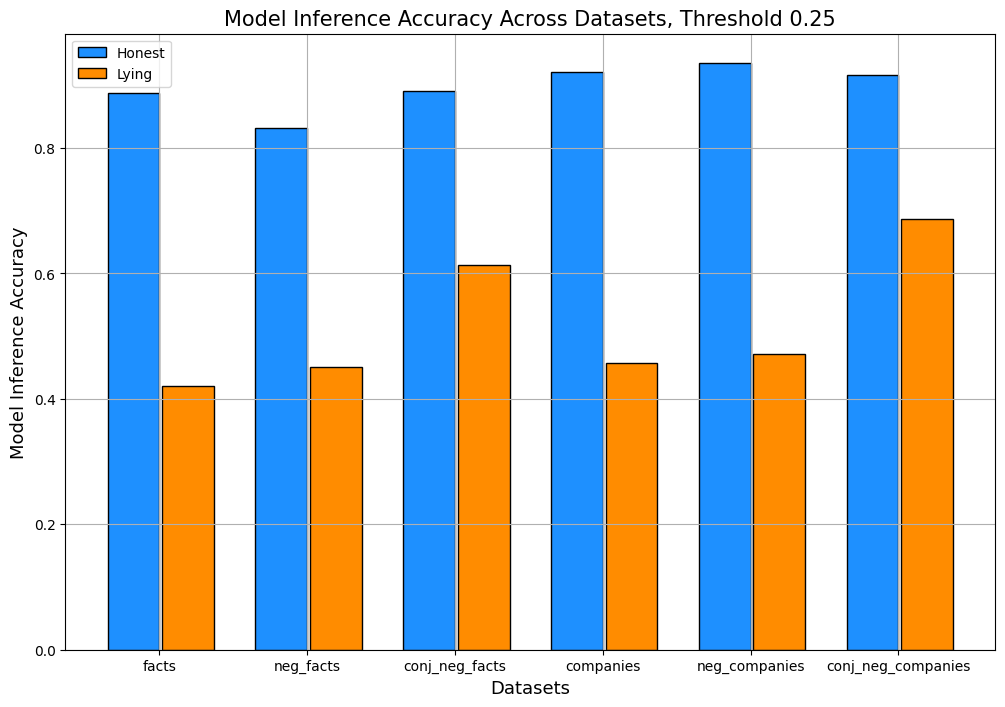

In [20]:
# Initialize plot
threshold = 0.25

plt.figure(figsize=(10, 8))

# Initialize some empty lists to store accuracy values
accuracies_honest = []
accuracies_lying = []

# Loop through datasets and modes to fill the accuracy lists
# This part you will have to replace with how you are getting your 'correct_prob' values
for dataset_name in tqdm(datasets):
    for mode in modes:
        # your code to get correct_prob goes here.
        correct_probs, incorrect_probs = act_dict[dataset_name][mode].get_inference_accuracy(tokenizer, scale_relative=True, threshold=threshold)
        
        correct_prob = np.mean(correct_probs)

        if mode == "honest":
            accuracies_honest.append(correct_prob)
        else:
            accuracies_lying.append(correct_prob)


# Setting the positions and width for the bars
pos = list(range(len(datasets)))
bar_width = 0.35

# Additional spacing between sub-bars within each group
spacing = 0.02

# Plotting the bars
fig, ax = plt.subplots(figsize=(12, 8))

# Create a bar with honest data, in position pos
plt.bar(pos, accuracies_honest, bar_width, label='Honest',
        color='dodgerblue', edgecolor='black')
# Remove y-axis grid lines

# Create a bar with lying data, in position pos + bar_width + spacing
plt.bar([p + bar_width + spacing for p in pos], accuracies_lying, bar_width, label='Lying',
        color='darkorange', edgecolor='black')

# Set the x-axis labels
ax.set_xticks([p + 0.5 * bar_width for p in pos])
# truncated_dataset_names = [dataset[16:] for dataset in datasets]
ax.set_xticklabels(datasets)

# Add labels and title
plt.xlabel('Datasets', fontsize=13)
plt.ylabel('Model Inference Accuracy', fontsize=13)
plt.title(f'Model Inference Accuracy Across Datasets, Threshold {threshold}', fontsize=15)

# Adding the legend and showing the plot
plt.legend(['Honest', 'Lying'], loc='upper left')
plt.grid()
plt.show()

## Probe Accuracy and Transfer

First, just regular in-distribution probe accuracy

In [23]:
act_type = "z"
average_layer = True

dataset_name = "facts"
dataset_acts = act_dict[dataset_name]

from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=len(modes))

for i, label in enumerate(modes):
    px_fig = get_px_fig(act_type, dataset_acts[label].probe_accs[act_type], n_layers, n_heads, title = f"{label} {act_type} Probe Accuracies", average_layer=average_layer)
    fig.add_trace(
        px_fig['data'][0],  # add the trace from plotly express figure
        row=1,
        col=i+1
    )

    if act_type == "z":
        fig.update_xaxes(title_text=f"Heads ({label})", row=1, col=i+1)
    else:
        fig.update_xaxes(title_text=f"Layer ({label})", row=1, col=i+1)
        fig.update_yaxes(title_text=px_fig.layout.yaxis.title.text, row=1, col=i+1)

    print(acc_tensor_from_dict(dataset_acts[label].probe_accs["z"], n_layers, n_heads).mean())

fig.update_yaxes(title_text=px_fig.layout.yaxis.title.text, row=1, col=1)


fig.update_layout(title_text=f"{act_type} Probe Accuracies, Dataset {dataset_name}, Sequence Pos {seq_pos}", showlegend=False)
fig.show()

0.6947298450630253
0.6486804096638655
0.6614266018907562


### Dataset Transfers

In [86]:
from utils.analytics_utils import plot_transfer_acc_subplots
transfer_mode = "liar"
percentile = 95
datasets = ["inventions", "elements", "animals", "facts", "companies", "capitals", "neg_facts", "neg_companies"]

train_acts = {dataset: act_dict[dataset][transfer_mode] for dataset in datasets}
test_acts = train_acts

cossim_tensors, _ = plot_transfer_acc_subplots(train_acts, test_acts, cosine_sim=True)

cossim_tensor_percentiles = np.percentile(einops.rearrange(cossim_tensors, "dataset1 dataset2 layer head -> dataset1 dataset2 (layer head)"), percentile, axis=-1)


inventions -> inventions
inventions -> elements
inventions -> animals
inventions -> facts
inventions -> companies
inventions -> capitals
inventions -> neg_facts
inventions -> neg_companies
elements -> inventions
elements -> elements
elements -> animals
elements -> facts
elements -> companies
elements -> capitals
elements -> neg_facts
elements -> neg_companies
animals -> inventions
animals -> elements
animals -> animals
animals -> facts
animals -> companies
animals -> capitals
animals -> neg_facts
animals -> neg_companies
facts -> inventions
facts -> elements
facts -> animals
facts -> facts
facts -> companies
facts -> capitals
facts -> neg_facts
facts -> neg_companies
companies -> inventions
companies -> elements
companies -> animals
companies -> facts
companies -> companies
companies -> capitals
companies -> neg_facts
companies -> neg_companies
capitals -> inventions
capitals -> elements
capitals -> animals
capitals -> facts
capitals -> companies
capitals -> capitals
capitals -> neg_fa

In [87]:
import plotly.graph_objects as go
x = np.arange(0, len(datasets))
y = np.arange(0, len(datasets))

# Create a figure
# fig = px.imshow(cossim_tensor_percentiles,
#                 labels=dict(x="Test Datasets", y="Train Datasets", color="Value"),
#                 x=x,
#                 y=y,
#                 color_continuous_scale="YlGnBu")  # You can change the color scale as needed
fig = go.Figure(data=go.Heatmap(
    z=cossim_tensor_percentiles[:,::-1],
    x=datasets,
    y=datasets[::-1],
    colorbar=dict(title='Accuracy'),
    colorscale='Viridis'
))

for i in range(0, len(y)):
    for j in range(0, len(x)):
        fig.add_annotation(
            x=j,
            y=i,
            text=str(round(cossim_tensor_percentiles[i, len(datasets)-1-j], 2)),
            showarrow=False,
            font=dict(
                color="black",
                size=12
            )
        )

fig.update_layout(width=600, height=600, title=f"Cosine Similarities Between Datasets, {transfer_mode} {percentile} Percentile")
# Show the plot
fig.show()

### Multiple Sequence Positions

In [88]:
datasets_3 = ["azaria_mitchell_inventions", "azaria_mitchell_elements", "azaria_mitchell_animals", "azaria_mitchell_cities", "azaria_mitchell_facts", "azaria_mitchell_companies", "azaria_mitchell_capitals"]
modes = ["honest", "neutral", "liar"]
act_dict_3 = {}
for dataset_name in datasets_3:
    act_dict_3[dataset_name] = {}
    for mode in modes:
        act_dict_3[dataset_name][mode]: ModelActsLargeSimple = ModelActsLargeSimple()

seq_pos = -3
act_type = "z"
# act_types = ["logits", "resid_mid", "z", "mlp_out"]
act_types = ["z"]
modes = ["honest", "liar"]
dont_include = None
run_id = 5
formatted_data_folder = f"/home/phillipguo/formatted_runs/run_{run_id}"
# formatted_data_folder = f"/mnt/ssd-2/jamescampbell3/data/large_run_{run_id}/activations/formatted"
train_probes = True

for dataset_name in tqdm(datasets_3):
    for mode in modes:
        print(f"Loading activations from {mode} model on {dataset_name}")
        for act_type in act_types:
            file_prefix = f"{formatted_data_folder}/run_{run_id}_{mode}"
            if seq_pos is not None:
                file_prefix += f"_{seq_pos}"
            file_prefix += f"_{act_type}"
            if dataset_name is not None:
                file_prefix += f"_{dataset_name}"

            with open(f"{formatted_data_folder}/labels_{run_id}_{mode}_{seq_pos}_z_{dataset_name}.pt", "rb") as handle:
                labels = torch.load(handle)
            
            act_dict_3[dataset_name][mode].load_acts(file_prefix, n_layers, n_heads=n_heads, labels=labels, exclude_points=dont_include, act_type=act_type, verbose=False)

            if act_type != "logits" and train_probes:
                act_dict_3[dataset_name][mode].train_probes(act_type, verbose=False, max_iter=10000)
    print(f"{dataset_name} dataset Size: {labels.shape[0]}")

  0%|          | 0/7 [00:00<?, ?it/s]

Loading activations from honest model on azaria_mitchell_inventions
Loading activations from liar model on azaria_mitchell_inventions


 14%|█▍        | 1/7 [00:51<05:08, 51.34s/it]

azaria_mitchell_inventions dataset Size: 379
Loading activations from honest model on azaria_mitchell_elements
Loading activations from liar model on azaria_mitchell_elements


 29%|██▊       | 2/7 [01:45<04:24, 52.95s/it]

azaria_mitchell_elements dataset Size: 387
Loading activations from honest model on azaria_mitchell_animals
Loading activations from liar model on azaria_mitchell_animals


 43%|████▎     | 3/7 [02:40<03:35, 53.88s/it]

azaria_mitchell_animals dataset Size: 429
Loading activations from honest model on azaria_mitchell_cities
Loading activations from liar model on azaria_mitchell_cities


 57%|█████▋    | 4/7 [05:46<05:18, 106.15s/it]

azaria_mitchell_cities dataset Size: 3331
Loading activations from honest model on azaria_mitchell_facts
Loading activations from liar model on azaria_mitchell_facts


 71%|███████▏  | 5/7 [06:29<02:46, 83.21s/it] 

azaria_mitchell_facts dataset Size: 257
Loading activations from honest model on azaria_mitchell_companies
Loading activations from liar model on azaria_mitchell_companies


 86%|████████▌ | 6/7 [07:25<01:14, 74.07s/it]

azaria_mitchell_companies dataset Size: 542
Loading activations from honest model on azaria_mitchell_capitals
Loading activations from liar model on azaria_mitchell_capitals


100%|██████████| 7/7 [08:26<00:00, 72.31s/it]


azaria_mitchell_capitals dataset Size: 628


  0%|          | 0/7 [00:00<?, ?it/s]

Loading activations from honest model on inventions


KeyError: 'inventions'

In [92]:
seq_pos = -1
act_type = "z"
act_types = ["z"]
dont_include = None
run_id = 6
formatted_data_folder = f"/home/phillipguo/formatted_runs/run_{run_id}"
# formatted_data_folder = f"/mnt/ssd-2/jamescampbell3/data/large_run_{run_id}/activations/formatted"
train_probes = True

datasets_1 = [dataset_name[16:] for dataset_name in datasets_3]
act_dict_1 = {}
for dataset_name in datasets_1:
    act_dict_1[dataset_name] = {}
    for mode in modes:
        act_dict_1[dataset_name][mode]: ModelActsLargeSimple = ModelActsLargeSimple()

for dataset_name in tqdm(datasets_1):
    for mode in modes:
        print(f"Loading activations from {mode} model on {dataset_name}")
        for act_type in act_types:
            file_prefix = f"{formatted_data_folder}/run_{run_id}_{mode}"
            if seq_pos is not None:
                file_prefix += f"_{seq_pos}"
            file_prefix += f"_{act_type}"
            if dataset_name is not None:
                file_prefix += f"_{dataset_name}"

            with open(f"{formatted_data_folder}/labels_{run_id}_{mode}_{seq_pos}_z_{dataset_name}.pt", "rb") as handle:
                labels = torch.load(handle)
            
            act_dict_1[dataset_name][mode].load_acts(file_prefix, n_layers, n_heads=n_heads, labels=labels, exclude_points=dont_include, act_type=act_type, verbose=False)

            if act_type != "logits" and train_probes:
                act_dict_1[dataset_name][mode].train_probes(act_type, verbose=False, max_iter=10000)
    print(f"{dataset_name} dataset Size: {labels.shape[0]}")

  0%|          | 0/7 [00:00<?, ?it/s]

Loading activations from honest model on inventions
Loading activations from liar model on inventions


 14%|█▍        | 1/7 [01:19<07:57, 79.61s/it]

inventions dataset Size: 876
Loading activations from honest model on elements
Loading activations from liar model on elements


 29%|██▊       | 2/7 [02:40<06:41, 80.40s/it]

elements dataset Size: 930
Loading activations from honest model on animals
Loading activations from liar model on animals


 43%|████▎     | 3/7 [03:58<05:17, 79.38s/it]

animals dataset Size: 1008
Loading activations from honest model on cities
Loading activations from liar model on cities


 57%|█████▋    | 4/7 [13:19<13:28, 269.44s/it]

cities dataset Size: 7576
Loading activations from honest model on facts
Loading activations from liar model on facts


 71%|███████▏  | 5/7 [14:07<06:19, 189.66s/it]

facts dataset Size: 599
Loading activations from honest model on companies
Loading activations from liar model on companies


 86%|████████▌ | 6/7 [15:23<02:30, 150.80s/it]

companies dataset Size: 1200
Loading activations from honest model on capitals
Loading activations from liar model on capitals


100%|██████████| 7/7 [16:52<00:00, 144.62s/it]

capitals dataset Size: 1452


### Next, transfer to Neg and Conj

In [23]:
# 
dataset_name = "all_am"
act_dict[dataset_name] = {"honest": ModelActsLargeSimple(), "liar": ModelActsLargeSimple(), "neutral": ModelActsLargeSimple()}
sub_datasets_long = ["azaria_mitchell_inventions", "azaria_mitchell_elements", "azaria_mitchell_animals", "azaria_mitchell_facts", "azaria_mitchell_companies", "azaria_mitchell_capitals", "azaria_mitchell_cities"]
sub_datasets_short = [dataset[16:] for dataset in sub_datasets_long]
act_types = ["z"]

for mode in ["honest", "liar"]:
    for act_type in act_types:
        
        file_prefixes = []
        file_prefix = f"{formatted_data_folder}/run_{run_id}_{mode}"
        if seq_pos is not None:
            file_prefix += f"_{seq_pos}"
        file_prefix += f"_{act_type}"


        all_labels = []
        for sub_name in sub_datasets_short:
            file_prefixes.append(f"{file_prefix}_{sub_name}")
            with open(f"{formatted_data_folder}/labels_{run_id}_{mode}_{seq_pos}_z_{sub_name}.pt", "rb") as handle:
                all_labels.append(torch.load(handle))
        # print(labels)
        labels = torch.cat(all_labels, dim=0)
        print(f"{labels.shape=}")
        
        act_dict[dataset_name][mode].load_acts(None, n_layers, n_heads=n_heads, labels=labels, exclude_points=dont_include, act_type=act_type, verbose=True, file_prefixes=file_prefixes)

        if act_type != "logits" and train_probes:
            act_dict[dataset_name][mode].train_probes(act_type, verbose=True, max_iter=10000, in_order=False)

labels.shape=torch.Size([13641])


100%|██████████| 5120/5120 [06:59<00:00, 12.20it/s]


labels.shape=torch.Size([13641])


100%|██████████| 5120/5120 [07:07<00:00, 11.98it/s]


In [28]:
from utils.analytics_utils import plot_z_probe_accuracies, plot_resid_probe_accuracies, plot_transfer_acc_subplots

train_acts = {"all_honest": act_dict["all_am"]["honest"], "all_liar": act_dict["all_am"]["liar"]}
test_acts = {"neg_facts_honest": act_dict["neg_facts"]["honest"], "neg_facts_liar": act_dict["neg_facts"]["liar"], "neg_companies_honest": act_dict["neg_companies"]["honest"], "neg_companies_liar": act_dict["neg_companies"]["liar"]}#, "conj_neg_companies_honest": act_dict["conj_neg_companies"]["honest"], "conj_neg_companies_liar": act_dict["conj_neg_companies"]["liar"]}

transfer_acc_tensors, fig = plot_transfer_acc_subplots(train_acts, test_acts)


all_honest -> neg_facts_honest
all_honest -> neg_facts_liar
all_honest -> neg_companies_honest
all_honest -> neg_companies_liar
all_liar -> neg_facts_honest
all_liar -> neg_facts_liar
all_liar -> neg_companies_honest
all_liar -> neg_companies_liar


In [29]:
fig.update_layout(
    width=800,
    height=500,
    title=f"Transfer from Probing on All Datasets to Negated Datasets",
)
fig.show()

### Misaligned Activations

In [59]:
# 
dataset_name = "decept"
act_types = ["z", "logits"]
act_dict[dataset_name] = {"misaligned": ModelActsLargeSimple()}
run_id = 101
formatted_data_folder = f"/home/phillipguo/formatted_runs/run_{run_id}"

for mode in ["misaligned"]:
    for act_type in act_types:
        
        file_prefixes = []
        file_prefix = f"{formatted_data_folder}/run_{run_id}_{mode}"
        if seq_pos is not None:
            file_prefix += f"_{seq_pos}"
        file_prefix += f"_{act_type}"


        all_labels = []
        file_prefixes.append(f"{file_prefix}_{dataset_name}")
        with open(f"{formatted_data_folder}/labels_{run_id}_{mode}_{seq_pos}_z_{dataset_name}.pt", "rb") as handle:
            all_labels.append(torch.load(handle))
        # print(labels)
        labels = torch.cat(all_labels, dim=0)
        print(f"{labels.shape=}")
        
        act_dict[dataset_name][mode].load_acts(None, n_layers, n_heads=n_heads, labels=labels, exclude_points=dont_include, act_type=act_type, verbose=True, file_prefixes=file_prefixes)

        if act_type != "logits" and train_probes:
            act_dict[dataset_name][mode].train_probes(act_type, verbose=True, max_iter=10000, in_order=False)

labels.shape=torch.Size([924])


100%|██████████| 5120/5120 [00:33<00:00, 153.89it/s]


labels.shape=torch.Size([924])


100%|██████████| 80/80 [00:07<00:00, 10.28it/s]


In [64]:
act_dict["decept"]["misaligned"].get_inference_accuracy(tokenizer, scale_relative=True)[0].mean()
act_dict["decept"]["misaligned"].get_inference_accuracy(tokenizer, scale_relative=True)[1].mean()

0.7590468

In [36]:
train_acts = {"decept_misaligned": act_dict["decept"]["misaligned"]}
# test_acts = {"neg_facts_honest": act_dict["neg_facts"]["honest"], "neg_facts_liar": act_dict["neg_facts"]["liar"], "neg_companies_honest": act_dict["neg_companies"]["honest"], "neg_companies_liar": act_dict["neg_companies"]["liar"]}#, "conj_neg_companies_honest": act_dict["conj_neg_companies"]["honest"], "conj_neg_companies_liar": act_dict["conj_neg_companies"]["liar"]}

transfer_acc_tensors, fig = plot_transfer_acc_subplots(train_acts, train_acts)

fig.update_layout(
    width=500,
    height=500,
    title=f"Misaligned Deception Probe Accuracy",
)
fig.show()

decept_misaligned -> decept_misaligned


In [53]:
train_acts = {"all_am_honest": act_dict["all_am"]["honest"], "all_am_liar": act_dict["all_am"]["liar"]}
test_acts = {"decept_misaligned": act_dict["decept"]["misaligned"]}

transfer_acc_tensors, fig = plot_transfer_acc_subplots(train_acts, test_acts)

fig.update_layout(
    width=400,
    height=1000,
    title=f"Misaligned Deception Probe Accuracy",
)
fig.show()

all_am_honest -> decept_misaligned
all_am_liar -> decept_misaligned


### Test deception onto harmful

In [56]:
harmful_act_dict = {}
act_types = ["z", "logits"]
dataset_name = "harmful"
dont_include = None
run_id = 9
data_folder = f"/mnt/ssd-2/jamescampbell3/data/large_run_{run_id}"
modes = ["honest", "liar"]
seq_pos = -1

for mode in tqdm(modes):
    harmful_act_dict[mode] = ModelActsLargeSimple()
    for act_type in act_types:
        file_prefix = f"{data_folder}/activations/formatted/run_{run_id}_{mode}"
        if seq_pos is not None:
            file_prefix += f"_{seq_pos}"
        file_prefix += f"_{act_type}"
        if dataset_name is not None:
            file_prefix += f"_{dataset_name}"

        with open(f"{data_folder}/activations/formatted/labels_{run_id}_{mode}_{seq_pos}_z_{dataset_name}.pt", "rb") as handle:
            labels = torch.load(handle)
            # print(f"{labels.shape=}")
        # print(labels)
        true_indices = torch.where(labels != 0)[0]
        false_indices = torch.where(labels == 0)[0]
        labels = labels[true_indices]
        # print(labels)

        harmful_act_dict[mode].load_acts(file_prefix, n_layers, n_heads=n_heads, labels=labels, exclude_points=false_indices, act_type=act_type)

100%|██████████| 2/2 [01:49<00:00, 54.60s/it]


In [58]:
train_acts = {"decept_misaligned": act_dict["decept"]["misaligned"]}
test_acts = {"harmful_honest": harmful_act_dict["honest"], "harmful_liar": harmful_act_dict["liar"]}

transfer_acc_tensors, fig = plot_transfer_acc_subplots(train_acts, test_acts)

fig.update_layout(
    width=800,
    height=500,
    title=f"Misaligned Deception Probe Transferred to Harmful",
)
fig.show()

decept_misaligned -> harmful_honest
decept_misaligned -> harmful_liar


### Standard z transfer accuracy on azaria mitchell

In [30]:
# Honest-Liar Probe Transfer for AZ Facts
from utils.analytics_utils import plot_z_probe_accuracies, plot_resid_probe_accuracies, plot_transfer_acc_subplots

dataset_name = "all_am"
train_acts = {mode: act_dict[dataset_name][mode] for mode in ["honest", "liar"]}

_, fig = plot_transfer_acc_subplots(train_acts, train_acts)
fig.update_layout(
    width=400,
    height=500,
    title=f"Transfer z Probe Accuracies on {dataset_name}"
)
fig.show()

honest -> honest
honest -> liar
liar -> honest
liar -> liar


In [59]:
_, fig = plot_transfer_acc_subplots(train_acts, train_acts, cosine_sim=True)
fig.update_layout(
    width=600,
    height=800,
    title=f"Cosine Similarities of Probe Coefficients on azaria_mitchell_{dataset_name}"
)
fig.show()

honest -> honest
honest -> liar
liar -> honest
liar -> liar


## Analyze Probe Accuracy vs Inference Accuracy
Make plot of probe accuracies vs inference accuracy

In [61]:
# Get indices of rows of each dataset in the big dataset
from datasets import load_dataset
dataset_name = "notrichardren/truthfulness_high_quality"
dataset = load_dataset(dataset_name)

#get the rows that have azaria_mitchell_facts as their value for the dataset column
dataset_indices = {dataset_name: [row['ind'] for row in dataset["combined"] if row['dataset'] == dataset_name] for dataset_name in tqdm(datasets)}

100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


In [16]:
# Format logits into formatted style: run_{run_id}_{mode}_{seq_pos}_logits_{dataset_name}.pt
seq_pos = -1
for dataset_name in tqdm(datasets):
    
    for mode in ["honest", "liar"]:
        logits = []
        for data_index in dataset_indices[dataset_name]:
            with open(f"activations/inference_outputs/logits_{run_id}_{mode}_{data_index}.pt", "rb") as handle:
                logits.append(torch.load(handle))
        logits = torch.cat(logits, dim=0)
        with open(f"activations/formatted/run_{run_id}_{mode}_{seq_pos}_logits_{dataset_name}.pt", "wb") as handle:
            torch.save(logits, handle)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


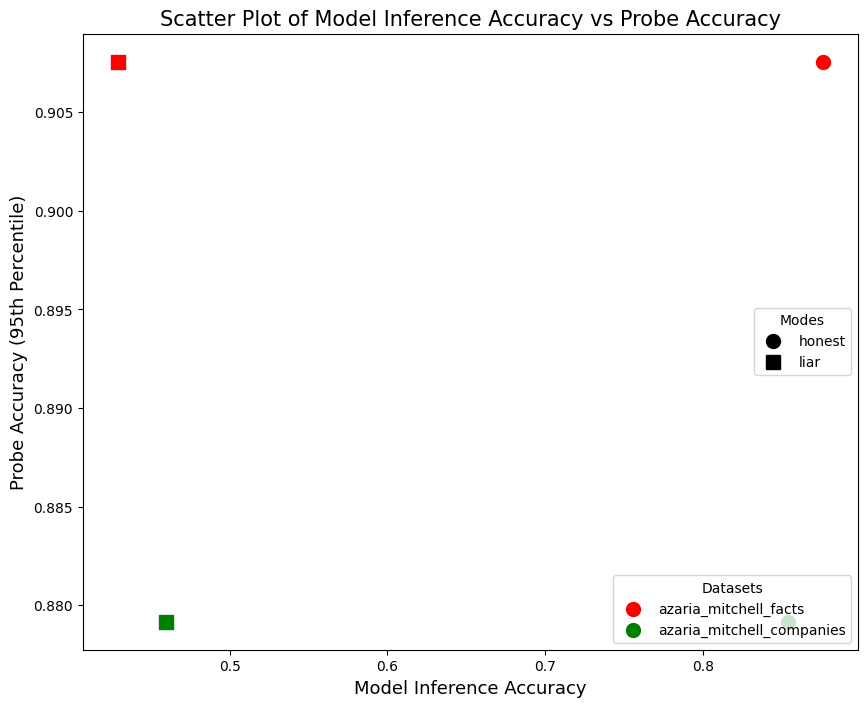

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

act_type = "z"

# Initialize plot
plt.figure(figsize=(10, 8))

# Define a color map
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
markers = ['o', 's']

dataset_legend_handles = []

for dataset_idx, dataset_name in enumerate(tqdm(datasets)):
    for mode_idx, mode in enumerate(modes):
        correct_probs, incorrect_probs = act_dict[dataset_name][mode].get_inference_accuracy(tokenizer, scale_relative=True)
        
        correct_prob = np.mean(correct_probs)
        probe_accs = acc_tensor_from_dict(act_dict[dataset_name][mode].probe_accs[act_type], n_layers=n_layers, n_heads=n_heads)
        probe_acc = np.percentile(probe_accs, 95)
        sc = plt.scatter(correct_prob, probe_acc, color=colors[dataset_idx], label=f"{dataset_name}-{mode}", marker=markers[mode_idx], s=100)

        if mode_idx == 0:
            dataset_legend_handles.append(sc)

mode_legend_handles = []
for marker in markers:
    mode_legend_handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=10))


plt.xlabel("Model Inference Accuracy", fontsize=13)
plt.ylabel("Probe Accuracy (95th Percentile)", fontsize=13)
plt.title("Scatter Plot of Model Inference Accuracy vs Probe Accuracy", fontsize=15)

# Add legend using only the handles we've collected
first_legend = plt.legend(dataset_legend_handles, datasets, title='Datasets', loc='lower right')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

plt.legend(mode_legend_handles, modes, title="Modes", loc="center right")
plt.show()

In [12]:
from utils.cache_utils import create_probe_dataset
data_dir = "/mnt/ssd-2/jamescampbell3"
act_type = "z"
run_id = 6
save_dir = f"/home/phillipguo/formatted_runs/run_{run_id}"

azaria_mitchell_splits = ['cities', 
                          'capitals', 
                          'companies', 
                          'animals', 
                          'elements', 
                          'inventions', 
                          'facts', 
                          'neg_companies', 
                          'neg_facts', 
                          'conj_neg_companies', 
                          'conj_neg_facts'
                          ]
for split in azaria_mitchell_splits:
    create_probe_dataset(run_id=run_id, seq_pos=-1, prompt_tag="liar", act_type=act_type, data_dir=data_dir, splits=[split], save_path=save_dir)


len(probe_indices)=7576


7576it [00:08, 885.82it/s] 
layer: 100%|██████████| 80/80 [00:47<00:00,  1.68it/s]


len(probe_indices)=1452


1452it [00:01, 841.77it/s]
layer: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]


len(probe_indices)=1200


1200it [00:01, 910.67it/s] 
layer: 100%|██████████| 80/80 [00:07<00:00, 11.15it/s]


len(probe_indices)=1008


1008it [00:07, 130.77it/s]
layer: 100%|██████████| 80/80 [00:04<00:00, 17.00it/s]


len(probe_indices)=930


930it [00:06, 140.00it/s]
layer: 100%|██████████| 80/80 [00:04<00:00, 18.73it/s]


len(probe_indices)=876


876it [00:06, 144.21it/s]
layer: 100%|██████████| 80/80 [00:05<00:00, 13.53it/s]


len(probe_indices)=599


599it [00:00, 1175.21it/s]
layer: 100%|██████████| 80/80 [00:04<00:00, 17.88it/s]


len(probe_indices)=1000


1000it [00:07, 133.92it/s]
layer: 100%|██████████| 80/80 [00:08<00:00,  9.16it/s]


len(probe_indices)=1096


1096it [00:08, 136.38it/s]
layer: 100%|██████████| 80/80 [00:04<00:00, 17.01it/s]


len(probe_indices)=550


550it [00:03, 140.58it/s]
layer: 100%|██████████| 80/80 [00:03<00:00, 22.64it/s]


len(probe_indices)=561


561it [00:03, 150.10it/s]
layer: 100%|██████████| 80/80 [00:04<00:00, 16.01it/s]
